# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="envs/tennis/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.10000000149011612
Score (max over agents) from episode 4: 0.10000000149011612
Score (max over agents) from episode 5: 0.09000000171363354


When finished, you can close the environment.

In [6]:
np.random.randn(num_agents, action_size)

array([[ 0.12440662, -0.59382643],
       [-0.23641668,  1.98722977]])

In [21]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
import numpy as np
from numpy.random import choice
import copy

In [39]:
env = UnityEnvironment(file_name="envs/tennis/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [40]:

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [41]:
# env.close()

In [42]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    def __init__(self, nA, nS, seed):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.dense1 = nn.Linear(nS, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dense2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dense3 = nn.Linear(128, nA)
        self.reset_parameters()
    
    def reset_parameters(self):
        self.dense1.weight.data.uniform_(*hidden_init(self.dense1))
        self.dense2.weight.data.uniform_(*hidden_init(self.dense2))
        self.dense3.weight.data.uniform_(-3e-3, 3e-3)
    
    def forward(self, state, training=True):
#         x = F.leaky_relu(self.bn1(self.dense1(state)))
#         x = F.leaky_relu(self.bn2(self.dense2(x)))
#         x = F.tanh(self.dense3(x))
        x = F.leaky_relu(self.dense1(state))
        x = F.leaky_relu(self.dense2(x))
        x = F.tanh(self.dense3(x))
        return x

In [43]:
class Critic(nn.Module):
    def __init__(self, nA, nS, seed):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.dense1 = nn.Linear(nS, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dense2 = nn.Linear(nA+256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dense3 = nn.Linear(128, 1)
        self.reset_parameters()
    
    def reset_parameters(self):
        self.dense1.weight.data.uniform_(*hidden_init(self.dense1))
        self.dense2.weight.data.uniform_(*hidden_init(self.dense2))
        self.dense3.weight.data.uniform_(-4e-3, 4e-3)
    
    def forward(self, state, action, training=True):
#         x = F.leaky_relu(self.bn1(self.dense1(state))).float()
#         x = F.leaky_relu(self.bn2(self.dense2(torch.cat((x, action.float()), 1))))
#         x = F.tanh(self.dense3(x))

        x = F.leaky_relu(self.dense1(state))
        x = torch.cat((x, action), 1)
        x = F.leaky_relu(self.dense2(x))
        x = self.dense3(x)
        
        return x

In [44]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, nA, nS, seed, prioritized=False, e=0.1):
        self.e=e
        self.nA = nA
        self.nS = nS
        self.memory = deque(maxlen=buffer_size)
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.prioritized = prioritized
        self.seed = random.seed(seed)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done", "tdE"])
        
    def add(self, state, action, reward, next_state, done, tdE):
        e = self.experience(state, action, reward, next_state, done, tdE)
        self.memory.append(e)
        
    def sample(self, a=0):
#         PRIORITY REPLAY first attempt
#         a = 0 if not self.prioritized
#         experiences = random.sample(self.memory, k=self.batch_size)
#         _, _, _, _, _, tdEs = zip(*self.memory)
#         tdEs = np.array(list(tdEs))
#         tdErrors = (np.abs(tdEs) + self.e)**a
#         tdErrorsSum = np.sum(tdErrors)
#         probabilities = tdErrors / tdErrorsSum
#         experiencesIdx = choice(np.arange(len(tdEs)), self.batch_size, p=probabilities)
#         experiences = [self.memory[c] for c in experiencesIdx]

#         probabilities = torch.from_numpy(np.vstack(probabilities)).float().to(device)
        probabilities = None
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.stack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.stack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.stack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones, probabilities)
        
    def __len__(self):
        return len(self.memory)

In [45]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

In [46]:
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 128   
GAMMA = 0.99       
TAU = 1e-3      
LR_ACTOR = 1e-4       
LR_CRITIC = 1e-4     
WEIGHT_DECAY = 0.0001 
UPDATE_EVERY = 10
UPDATE_NUM = 4
EPSILON = 1.0
EPS_DECAY = 5e-5
EPS_END=0.03
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [47]:
class Agent():
    def __init__(self, nA, nS, nAgents, idxAgent, room, seed, prioritized=False):
        self.prioritized = prioritized
        self.state_size = nS
        self.action_size = nA
        self.idxAgent = idxAgent
        self.room = room
        self.nAgents = nAgents
        
        self.critic_local = Critic(nA*nAgents, nS*nAgents, seed).to(device)
        self.critic_target = Critic(nA*nAgents, nS*nAgents, seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        
        self.actor_local = Actor(nA, nS, seed).to(device)
        self.actor_target = Actor(nA, nS, seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        
        self.t_step = 0
        self.ouNoise = OUNoise(nA, seed)
        
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, nA, nS, seed, prioritized=False, e=0.1)
        self.epsilon = EPSILON
        
    def step(self, states, actions, rewards, next_states, dones, a=0, b=1):
        tdE = 1.0
#         for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
#             self.memory.add(state, action, reward, next_state, done, tdE)
        self.memory.add(states, actions, rewards, next_states, dones, tdE)
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        

        if(self.t_step == 0):
            if(len(self.memory) > BATCH_SIZE):
                for i in range(UPDATE_NUM):
                    experiences = self.memory.sample(a)
                    self.learn(experiences, GAMMA, b)
                
    def act(self, state, training=True):
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action_values = self.actor_local(state)
        self.actor_local.train()
        av2 =action_values.cpu().numpy()
        if(training and (random.random() < self.epsilon)):
            self.epsilon -= EPS_DECAY
            if(self.epsilon < EPS_END):
                self.epsilon = EPS_END
            av2 += self.ouNoise.sample()
        return(np.clip(av2, -1, 1))
        
    
    def learn(self, experiences, gamma, b):
        states, actions, rewards, next_states, dones, probabilities = experiences
        next_actions = self.actor_target(next_states[:,self.idxAgent])
        next_actions = self.room.getNextActionsTarget(next_states)
        next_Qvalues = self.critic_target(next_states.view(BATCH_SIZE,self.nAgents*self.state_size), next_actions)
        
        Qtargets = rewards + (GAMMA*next_Qvalues * (1-dones))
        
        Qexpected = self.critic_local(states.view(BATCH_SIZE,self.nAgents*self.state_size), actions.view(BATCH_SIZE, self.nAgents*self.action_size))
        
        loss_critic = F.mse_loss(Qexpected, Qtargets)
        self.critic_optimizer.zero_grad()
        loss_critic.backward()
        torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1.0)
        self.critic_optimizer.step()
        
        actions_pred = self.actor_local(states[:,self.idxAgent])
        actions_pred = self.room.getActionsLocal(states)
        loss_actor = -self.critic_local(states.view(BATCH_SIZE,self.nAgents*self.state_size), actions_pred).mean()
        
        self.actor_optimizer.zero_grad()
        loss_actor.backward()
        self.actor_optimizer.step()
        
        self.soft_update(self.critic_local, self.critic_target, TAU)  
        self.soft_update(self.actor_local, self.actor_target, TAU)  
        
        
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
    
    def reset(self):
        self.ouNoise.reset()
        

In [48]:
class AgentWaitingRoom():
    def __init__(self, nAgents, nS, nA, seed=0):
        self.nAgents = nAgents
        self.nA = nA
        self.agents = [Agent(nA, nS, nAgents, agent, self, seed) for agent in range(nAgents)]
    def train(self, n_episodes=10000, max_t=2000, print_every=100):
        scores_all = [[] for i in range(self.nAgents)]
        score_windows = [deque(maxlen=100) for i in range(self.nAgents)]
        for i_episode in range(1, n_episodes+1):
            env_info = env.reset(train_mode=True)[brain_name]
            for agent in self.agents:
                agent.reset()
            states = env_info.vector_observations
            scores = np.zeros(self.nAgents)
            
            for t in range(max_t):
                actions = [agent.act(states[agent.idxAgent]) for agent in self.agents]
                env_info = env.step(actions)[brain_name]
                next_states = env_info.vector_observations
                rewards = env_info.rewards
                dones = env_info.local_done
                scores += env_info.rewards
                for agent in self.agents:
                    agent.step(states, actions, env_info.rewards[agent.idxAgent], next_states, dones[agent.idxAgent])
                states = next_states
                if(np.any(dones)):
                    break
            message = '\rEpisode {}'.format(i_episode)
            for i, score in enumerate(scores):
                score_windows[i].append(score)
                scores_all[i].append(score)
                message = message + '\tAverage Score: '+str(i)+' '+str(np.mean(score_windows[i]))
                
            
            print(message, end="")
            
            for agent in self.agents:
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_{}.pth'.format(agent.idxAgent))
                torch.save(agent.actor_local.state_dict(), 'checkpoint_critic_{}.pth'.format(agent.idxAgent))
                
            if i_episode % print_every == 0:
                print(message)
        return scores_all
    
    
    def getNextActionsTarget(self,next_states):
        nextActions = []
        for i, agent in enumerate(self.agents):
            agent.actor_target.eval()
            with torch.no_grad():
                next_actions = agent.actor_target(next_states[:,i])
                nextActions.append(next_actions)
            agent.actor_target.train()
            
        return torch.stack(nextActions, dim=1, out=None).view(BATCH_SIZE, self.nA*self.nAgents)

    def getActionsLocal(self, states):
        Actions = []
        for i, agent in enumerate(self.agents):
            agent.actor_local.eval()
            with torch.no_grad():
                actions = agent.actor_local(states[:,i])
                Actions.append(actions)
            agent.actor_local.train()    
        return torch.stack(Actions, dim=1, out=None).view(BATCH_SIZE, self.nA*self.nAgents)
            
                
        

In [49]:
room = AgentWaitingRoom(2, state_size, action_size)

In [ ]:
scores = room.train()

Episode 9	Average Score: 0 -0.002222222172551685	Average Score: 1 -0.0077777776039308977

c:\users\al\miniconda3\envs\mlagents\lib\site-packages\ipykernel_launcher.py:63: UserWarning: Using a target size (torch.Size([128, 128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
c:\users\al\miniconda3\envs\mlagents\lib\site-packages\ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Episode 100	Average Score: 0 -0.0034999999217689036	Average Score: 1 -0.0064999998547136785
Episode 200	Average Score: 0 -0.004999999888241291	Average Score: 1 -0.00499999988824129175
Episode 300	Average Score: 0 -0.003799999915063381	Average Score: 1 -0.00619999986141920155
Episode 400	Average Score: 0 -0.005599999874830246	Average Score: 1 -0.00439999990165233625
Episode 500	Average Score: 0 -0.004799999892711639	Average Score: 1 -0.00519999988377094375
Episode 600	Average Score: 0 -0.004999999888241291	Average Score: 1 -0.00499999988824129175
Episode 700	Average Score: 0 -0.004999999888241291	Average Score: 1 -0.00499999988824129175
Episode 800	Average Score: 0 -0.005199999883770943	Average Score: 1 -0.00479999989271163935
Episode 900	Average Score: 0 -0.005099999886006117	Average Score: 1 -0.00389999987557530455
Episode 1000	Average Score: 0 -0.002799999862909317	Average Score: 1 -0.0042999998666346075
Episode 1100	Average Score: 0 -0.004499999899417162	Average Score: 1 -0.00549999

In [37]:
env.close()

In [ ]:
def ddpg(n_episodes=10000, max_t=2000, print_every=100):
    scores_all1 = []
    score_window1 = deque(maxlen=100)
    
    scores_all2 = []
    score_window2 = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent1.reset()
        agent1.reset()
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        for t in range(max_t):
            curr_states = np.concatenate((states[0], states[1]), axis=None)
#             print(curr_states)
#             print(curr_states.shape)
            actions1 = agent1.act(curr_states)
            actions2 = agent2.act(curr_states)
            actions = np.array([actions1, actions2])
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations   
            rewards = env_info.rewards
            dones = env_info.local_done
            scores += env_info.rewards
            nxt_states = np.concatenate((next_states[0], next_states[1]), axis=None)
#             print(nxt_states)
#             print(nxt_states.shape)
            agent1.step(curr_states, actions[0], env_info.rewards[0], nxt_states, dones[0])
            agent2.step(curr_states, actions[1], env_info.rewards[1], nxt_states, dones[1])
            states = next_states
            if(np.any(dones)):
                break
        
        
#         score_mean = np.mean(scores)
        score_window1.append(scores[0])
        score_window2.append(scores[1])
        scores_all1.append(scores[0])
        scores_all2.append(scores[1])
        print('\rEpisode {}\tAverage Score 1: {:.2f}\tAverage Score 2: {:.2f}'.format(i_episode, np.mean(score_window1), np.mean(score_window2)), end="")
        torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor1.pth')
        torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic1.pth')
        torch.save(agent2.actor_local.state_dict(), 'checkpoint_actor2.pth')
        torch.save(agent2.critic_local.state_dict(), 'checkpoint_critic2.pth')
        if(scores[0]>=0.5):
            break
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score 1: {:.2f}\tAverage Score 2: {:.2f}'.format(i_episode, np.mean(score_window1), np.mean(score_window2)))
#     env.close()
    return scores_all1, scores_all2

In [102]:
scores1, scores2 = ddpg()

Episode 8	Average Score 1: -0.01	Average Score 2: 0.01

c:\users\jl\miniconda3\envs\mlagents\lib\site-packages\ipykernel_launcher.py:64: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Episode 100	Average Score 1: -0.00	Average Score 2: -0.00
Episode 200	Average Score 1: -0.00	Average Score 2: -0.00
Episode 300	Average Score 1: -0.00	Average Score 2: -0.01
Episode 400	Average Score 1: -0.01	Average Score 2: -0.00
Episode 500	Average Score 1: -0.01	Average Score 2: -0.00
Episode 600	Average Score 1: -0.00	Average Score 2: -0.01
Episode 700	Average Score 1: -0.00	Average Score 2: -0.01
Episode 800	Average Score 1: -0.01	Average Score 2: -0.00
Episode 900	Average Score 1: -0.00	Average Score 2: -0.01
Episode 1000	Average Score 1: -0.00	Average Score 2: -0.01
Episode 1100	Average Score 1: -0.01	Average Score 2: -0.00
Episode 1200	Average Score 1: -0.01	Average Score 2: -0.00
Episode 1300	Average Score 1: -0.00	Average Score 2: -0.01
Episode 1400	Average Score 1: -0.00	Average Score 2: -0.01
Episode 1500	Average Score 1: -0.01	Average Score 2: -0.00
Episode 1600	Average Score 1: -0.00	Average Score 2: -0.01
Episode 1700	Average Score 1: -0.00	Average Score 2: -0.01
Episod

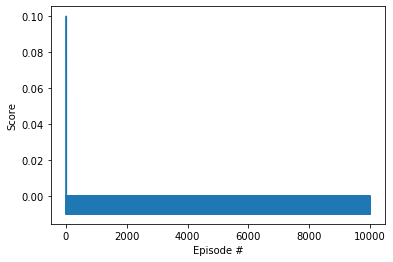

In [103]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores1)+1), scores1)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

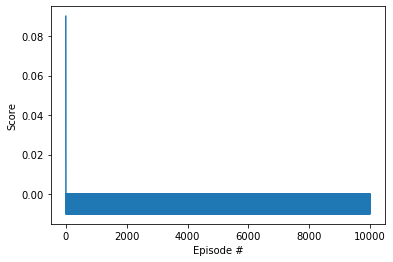

In [104]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores2)+1), scores2)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [105]:
for i in range(1, 20):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions1 = agent1.act(states[0], training=False)
        actions2 = agent2.act(states[1], training=False)
        actions = np.array([actions1, actions2])                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

RuntimeError: size mismatch, m1: [1 x 24], m2: [48 x 256] at C:/w/1/s/tmp_conda_3.6_081743/conda/conda-bld/pytorch_1572941935551/work/aten/src\THC/generic/THCTensorMathBlas.cu:290

In [48]:
env.close()